# Predict survival on the Titanic
In this Lab, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy

### Dataset
The dataset contains 891 observations of 12 variables:
* **PassengerId**: Unique ID for each passenger
* **Survived**: Survival (0 = No; 1 = Yes)
* **Pclass**: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* **Name**: Name
* **Sex**: Sex
* **Age**: Age
* **Sibsp**: Number of Siblings/Spouses Aboard
* **Parch**: Number of Parents/Children Aboard
* **Ticket**: Ticket Number
* **Fare**: Passenger Fare
* **Cabin**: Cabin
* **Embarked** Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [135]:
# imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [136]:
titanic = pd.read_csv("titanic.csv" )
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [137]:
# print some info about the dataframe
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Looks like there are some Nan values, let's see how many for each column

In [138]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Cabin** contains a lot of Nan values, we'll drop this column <br>
We'll replace the Nan values in **Age** with the age's median, and the ones in **Embarked** with **'S'**, which is the most frequent one in this column

In [139]:
titanic.drop( 'Cabin', axis=1, inplace=True)
# check the fillna documentation: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html
titanic["Age"].fillna(titanic["Age"].median(),inplace=True)
titanic["Embarked"].fillna("S", inplace = True)
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Visualization

survival rate = 0.3838383838383838


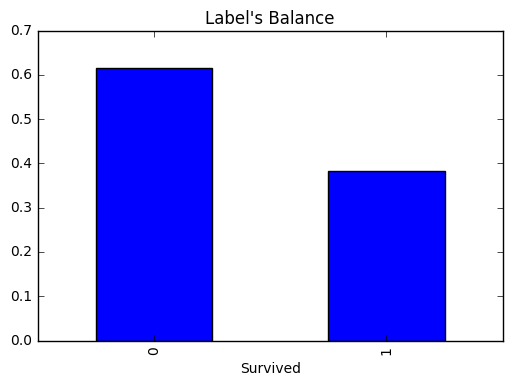

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
print ('survival rate =', titanic.Survived.mean())
(titanic.groupby('Survived').size()/titanic.shape[0]).plot(kind="bar",title="Label's Balance")


In [141]:
# make a function to plot survival against passenger attribute
def survival_rate(column,t):
    df=pd.DataFrame()
    df['total']=titanic.groupby(column).size()
    df['survived'] = titanic.groupby(column).sum()['Survived']
    df['percentage'] = round(df['survived']/df['total']*100,2)
    print(df)

    df['survived'].plot(kind=t)
    df['total'].plot(kind=t,alpha=0.5,title="Survivors per "+str(column))
    plt.show()

        total  survived  percentage
Sex                                
female    314       233       74.20
male      577       109       18.89


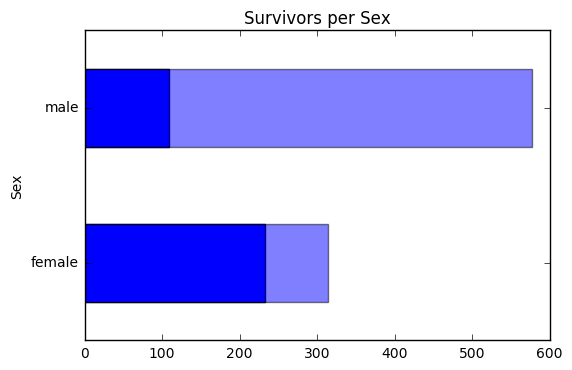

In [142]:
# Draw survival per Sex
survival_rate("Sex","barh")

        total  survived  percentage
Pclass                             
1         216       136       62.96
2         184        87       47.28
3         491       119       24.24


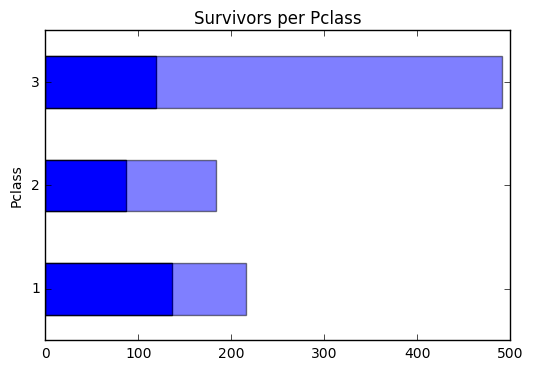

In [143]:
# Draw survival per Class
survival_rate("Pclass","barh")

          total  survived  percentage
Embarked                             
C           168        93       55.36
Q            77        30       38.96
S           646       219       33.90


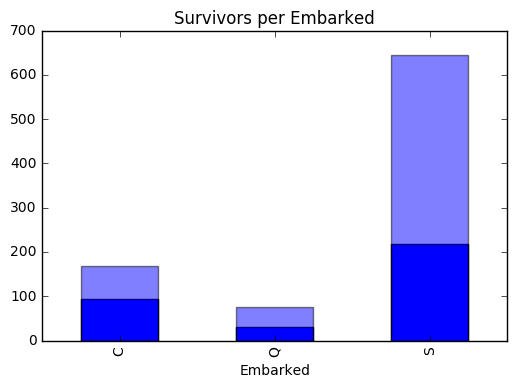

In [144]:
# Graph survived per port of embarkation
survival_rate("Embarked","bar")

       total  survived  percentage
Parch                             
0        678       233       34.37
1        118        65       55.08
2         80        40       50.00
3          5         3       60.00
4          4         0        0.00
5          5         1       20.00
6          1         0        0.00


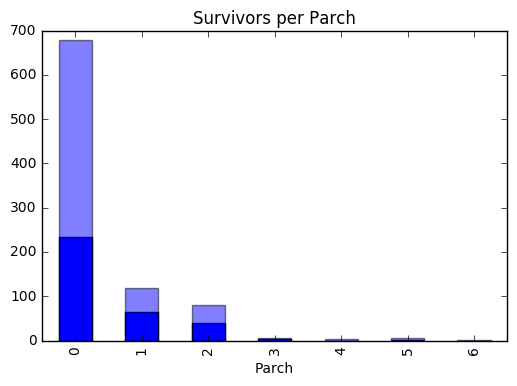

In [145]:
# Draw survived per Number of Parents/Children Aboard (Parch)
survival_rate("Parch","bar")

       total  survived  percentage
SibSp                             
0        608       210       34.54
1        209       112       53.59
2         28        13       46.43
3         16         4       25.00
4         18         3       16.67
5          5         0        0.00
8          7         0        0.00


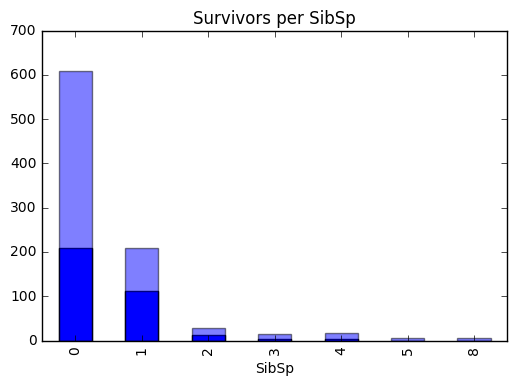

In [158]:
# Draw survived per Number of Siblings/Spouses Aboard (SibSp)
survival_rate("SibSp","bar")

## Model training

Some of the columns don't have predictive power, so let's specify which ones are included for prediction

In [146]:
predictors = ["Pclass", "Sex", "Age", 'SibSp' ,'Parch', "Fare", "Embarked"]  

We need now to convert text columns in **predictors** to numerical ones

In [147]:
for col in predictors: # Loop through all columns in predictors
    if titanic[col].dtype == 'object':  # check if column's type is object (text)
        titanic[col] = pd.Categorical(titanic[col]).codes  # convert text to numerical

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2


In [2]:
# Split the data into a training set and a testing set
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(titanic[predictors], titanic['Survived'], test_size=0.3, random_state=1)

print ("train shape", X_train.shape, y_train.shape)
print ("test shape", X_test.shape, y_test.shape)

NameError: name 'titanic' is not defined

In [149]:
# import LogisticRegression from: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)

train accuracy = 0.810593900482
test accuracy = 0.768656716418


Let's print the model's parameters

In [150]:
coeff = pd.DataFrame()
coeff['Feature'] = X_train.columns
coeff['Coefficient Estimate'] = pd.Series(clf.coef_[0])
coeff.loc[len(coeff)]=['Intercept',clf.intercept_[0]]
print (coeff)

     Feature  Coefficient Estimate
0     Pclass             -0.835661
1        Sex             -2.512474
2        Age             -0.026081
3       Fare              0.002659
4   Embarked             -0.117348
5      SibSp             -0.303038
6      Parch              0.067869
7  Intercept              3.803960


We now need to predict class labels for the test set. We will also generate the class probabilities

In [151]:
# predict class labels for the test set
y_pred = clf.predict(X_test)
print (y_pred)

[1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1
 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 1 1 0 1 1 0 0 0 0]


In [152]:
# generate class probabilities : http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
y_probs = clf.predict_proba(X_test)
print (y_probs)

[[ 0.17498658  0.82501342]
 [ 0.89654863  0.10345137]
 [ 0.18505074  0.81494926]
 [ 0.38437631  0.61562369]
 [ 0.12775857  0.87224143]
 [ 0.87836074  0.12163926]
 [ 0.79601829  0.20398171]
 [ 0.15990222  0.84009778]
 [ 0.58878627  0.41121373]
 [ 0.45324822  0.54675178]
 [ 0.88906335  0.11093665]
 [ 0.40004872  0.59995128]
 [ 0.74064084  0.25935916]
 [ 0.78754936  0.21245064]
 [ 0.38462019  0.61537981]
 [ 0.6079067   0.3920933 ]
 [ 0.91760024  0.08239976]
 [ 0.91184305  0.08815695]
 [ 0.91436184  0.08563816]
 [ 0.28507975  0.71492025]
 [ 0.90582535  0.09417465]
 [ 0.89643176  0.10356824]
 [ 0.07770015  0.92229985]
 [ 0.70858489  0.29141511]
 [ 0.34204162  0.65795838]
 [ 0.89391134  0.10608866]
 [ 0.06611173  0.93388827]
 [ 0.30213959  0.69786041]
 [ 0.77983473  0.22016527]
 [ 0.07156778  0.92843222]
 [ 0.3736765   0.6263235 ]
 [ 0.6054001   0.3945999 ]
 [ 0.45893842  0.54106158]
 [ 0.4679678   0.5320322 ]
 [ 0.91439336  0.08560664]
 [ 0.51526176  0.48473824]
 [ 0.656529    0.343471  ]
 

As you can see, the classifier outputs two probabilities for each row. It's predicting a 1 (Survived) any time the probability in the second column is greater than 0.5. Let's visualize it all together.

In [153]:
pred = pd.DataFrame({        
        "Survived_original": y_test,
        "Survived_predicted": y_pred,
        "Survived_proba": np.transpose(y_probs)[1]      
        })
pred["Comparison"]= pred.Survived_original ==pred.Survived_predicted
pred.head()

,Survived_original,Survived_predicted,Survived_proba,Comparison
862,1,1,0.825013,True
223,0,0,0.103451,True
84,1,1,0.814949,True
680,0,1,0.615624,False
535,1,1,0.872241,True


## Confusion matrix

In [154]:
from sklearn import metrics
print (metrics.confusion_matrix(y_test, y_pred))
print (metrics.classification_report(y_test, y_pred))

[[132  21]
 [ 41  74]]
             precision    recall  f1-score   support

          0       0.76      0.86      0.81       153
          1       0.78      0.64      0.70       115

avg / total       0.77      0.77      0.76       268



As you can see, we can have the classification report for each class

## K-Fold Cross Validation

In [155]:
# import cross_validation from: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
from sklearn import cross_validation
clf = LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(clf, titanic[predictors], titanic["Survived"], scoring='accuracy', cv=5)
## see model 
print(scores)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

[ 0.7877095   0.79888268  0.78089888  0.76404494  0.81920904]
0.790149007709


When you are improving a model, you want to make sur that you are really doing it and not just being lucky. This is why it's good to work with cross validation instead of one train/test split.